## Aggregator
This notebook contains the aggregation logic behind the summarization of experiment results with the same parameters on different dataset splits.

In [1]:
# Imports
import os
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import timedelta as td

In [2]:
def fill_values(df, total_budget):
    # Fill the missing values for `Timestamp` column
    ref_idx = 0 # the df index to copy from
    for i in range(1, total_budget): # 150
        if i not in df.Timestamp.values:
            n = df.shape[0]
            df.at[n, 'Timestamp'] = int(i)
            df.at[n, 'single_best_optimization_score'] = df.at[ref_idx, 'single_best_optimization_score']
            df.at[n, 'single_best_test_score'] = df.at[ref_idx, 'single_best_test_score']
        else:
            ref_idx = df.index[df['Timestamp'] == i][0]
            #print('Changing index at Timestamp =', i)
    df = df.iloc[1: , :]
    df = df.sort_values(by='Timestamp').reset_index(drop=True)
    df = df.astype({"Timestamp": int})
    return df

In [3]:
# Output directories
output_dirname = 'results'
output_path = os.path.join(Path.cwd(), output_dirname)
output_performance_path = os.path.join(output_path, 'performance')
# Import metadata
metadata_filepath = os.path.join(output_path, 'metadata.csv')
metadata_df = pd.read_csv(metadata_filepath)
# Remove individual edb (random search) runs
metadata_df = metadata_df[metadata_df['total_budget'] != 30]
# Extract experiment parameters
total_budget = metadata_df.total_budget[0]
dataset_list = list(metadata_df.dataset_name.unique())
validation_strategy_list = list(metadata_df.validation_strategy.unique())
validation_size_list = list(metadata_df.validation_size.unique())
search_algorithm_list = ['edb', 'random', 'smac']
# Print the parameters
print('Total budget:', total_budget)
print('Dataset list:', dataset_list)
print('Search algorithm list:', search_algorithm_list)
print('Validation strategy list:', validation_strategy_list)
print('Validation size list:', validation_size_list)

Total budget: 150
Dataset list: ['ALOI']
Search algorithm list: ['edb', 'random', 'smac']
Validation strategy list: ['stratified', 'balanced']
Validation size list: [1125]


In [4]:
# Calculate combinations
cross_prod = []
for algorithm in search_algorithm_list:
    for strategy in validation_strategy_list:
        for size in validation_size_list:
            cross_prod.append(
                '{}_{}_{}.csv'.format(
                    algorithm,
                    strategy,
                    size
                )
            )

ALOI
	edb_stratified_1125.csv
	edb_balanced_1125.csv
	random_stratified_1125.csv
	random_balanced_1125.csv
	smac_stratified_1125.csv


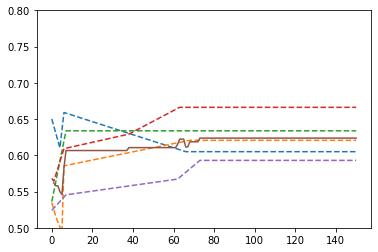

	smac_balanced_1125.csv


In [5]:
# Iterate over datasets
dataset_list = ['ALOI']
for dataset in dataset_list:
    print(dataset)
    for cp in cross_prod:
        df_list = []
        print('\t'+cp)
        for filename in os.listdir(output_performance_path):
            if dataset in filename and cp in filename:
                df = pd.read_csv(
                    os.path.join(
                        output_performance_path,
                        filename
                    ),
                    parse_dates=['Timestamp']
                )
                df.drop(columns=['single_best_train_score'], inplace=True)
                # Transform timestamp and boundary values
                df.Timestamp = (df.Timestamp-df.Timestamp[0]).apply(td.total_seconds)
                n = df.shape[0]
                df.at[n, 'Timestamp'] = total_budget
                df = df.astype({"Timestamp": int})
                df.at[n, 'single_best_optimization_score'] = df.at[n-1, 'single_best_optimization_score']
                df.at[n, 'single_best_test_score'] = df.at[n-1, 'single_best_test_score']
                df = df.drop_duplicates().reset_index(drop=True)
                plt.plot(df.Timestamp, df.single_best_test_score, '--')
                df = fill_values(df, total_budget)
                df_list.append(df)
                #print(df['single_best_test_score'].values[4])
                #df.to_csv(os.path.join(output_performance_path, '_'+filename), index=False)
        # Average
        if len(df_list) > 0:
            title = dataset+'_'+cp
            dff = df_list[0] # total
            for df in df_list[1:]:
                dff['single_best_optimization_score'] += df['single_best_optimization_score']
                dff['single_best_test_score'] += df['single_best_test_score']
            dff['single_best_optimization_score'] = dff['single_best_optimization_score'] / len(df_list)
            dff['single_best_test_score'] = dff['single_best_test_score'] / len(df_list)
            dff = dff.astype({"Timestamp": int})
            #print('avg:', dff['single_best_test_score'].values[4])
            dff.to_csv(os.path.join(output_performance_path, title), index=False)
            plt.plot(dff.Timestamp, dff.single_best_test_score)
            plt.ylim([0.5, 0.8])
            plt.show()